In [105]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='../../../../../../notebooks/Data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='../../../../../../notebooks/Data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = DataLoader(test_data, batch_size=500, shuffle=True)

torch.Size([1, 28, 28])


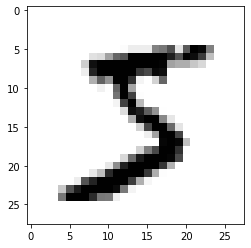

In [17]:
img, lbl = train_data[0]

print(img.shape)
plt.imshow(img.view(28, -1), cmap='gist_yarg')


In [82]:
# Model
class MultilayerPerceptron(nn.Module):

    def __init__(self, n_in=784, n_out=10, layers=(100, 50)):
        super().__init__()
        self.fc1 = nn.Linear(n_in, layers[0])
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc3 = nn.Linear(layers[1], n_out)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.log_softmax(self.fc3(x), dim=1)


model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)

In [83]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_loss = []
train_correct = []
test_loss = []
test_correct = []

In [84]:
epoch = 10

for i in range(epoch):

    trn_correct = 0
    tst_correct = 0

    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1

        y_pred = model.forward(X_train.view(100, -1))
        loss = criterion(y_pred, y_train)

        prediction = torch.max(y_pred, dim=1)[1]
        trn_correct += (prediction == y_train).sum()

        # Back propagate
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b % 200 == 0:
            accuracy = trn_correct.item() * 100 / (b * 100)
            print(f'epoch: {i}, batch: {b} -> loss: {loss}, accuracy: {accuracy}%')

    train_loss.append(loss)
    train_correct.append(trn_correct)

    with torch.no_grad():

        for b, (X_test, y_test) in enumerate(test_loader):

            y_val = model.forward(X_test.view(500, -1))
            loss = criterion(y_val, y_test)

            prediction = torch.max(y_val, dim=1)[1]
            tst_correct += (prediction == y_test).sum()

        test_loss.append(loss)
        test_correct.append(tst_correct)

epoch: 0, batch: 200 -> loss: 0.18964897096157074, accuracy: 81.755%
epoch: 0, batch: 400 -> loss: 0.1381261944770813, accuracy: 86.5825%
epoch: 0, batch: 600 -> loss: 0.26314443349838257, accuracy: 88.66333333333333%
epoch: 1, batch: 200 -> loss: 0.21957451105117798, accuracy: 93.915%
epoch: 1, batch: 400 -> loss: 0.13184577226638794, accuracy: 94.2875%
epoch: 1, batch: 600 -> loss: 0.06917045265436172, accuracy: 94.655%
epoch: 2, batch: 200 -> loss: 0.15803180634975433, accuracy: 95.675%
epoch: 2, batch: 400 -> loss: 0.1794023960828781, accuracy: 95.93%
epoch: 2, batch: 600 -> loss: 0.08122707158327103, accuracy: 96.05666666666667%
epoch: 3, batch: 200 -> loss: 0.043835949152708054, accuracy: 96.88%
epoch: 3, batch: 400 -> loss: 0.11294471472501755, accuracy: 96.85%
epoch: 3, batch: 600 -> loss: 0.14489735662937164, accuracy: 97.015%
epoch: 4, batch: 200 -> loss: 0.03934948891401291, accuracy: 97.63%
epoch: 4, batch: 400 -> loss: 0.03210097551345825, accuracy: 97.65%
epoch: 4, batch:

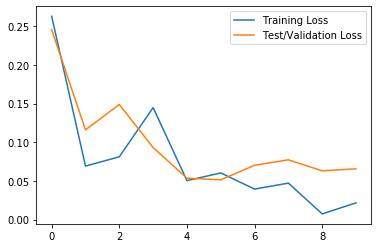

In [85]:
plt.plot(train_loss, label="Training Loss")
plt.plot(test_loss, label="Test/Validation Loss")
plt.legend()

# training_accuracy = [ / 600 for t in train_correct]

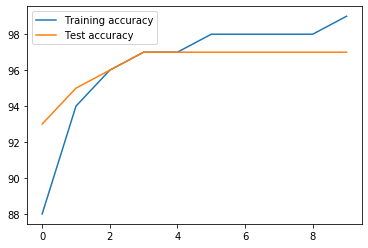

In [92]:
train_accuracy = [t / 600 for t in train_correct]
test_accuracy = [t / 100 for t in test_correct]

plt.plot(train_accuracy, label='Training accuracy')
plt.plot(test_accuracy, label='Test accuracy')
plt.legend()

In [99]:
# NEW UNSEEN DATA.
test_data_all = DataLoader(test_data, batch_size=10_000, shuffle=False)

with torch.no_grad():

    correct = 0
    for X_test, y_test in test_data_all:

        y_pred = model.forward(X_test.view(X_test.shape[0], -1))
        loss = criterion(y_pred, y_test)

        predictions = torch.max(y_pred, dim=1)[1]
        correct += (predictions == y_test).sum()

    print(f'{correct.item()} out of {X_test.shape[0]} is correct: {(correct.item() / X_test.shape[0]) * 100}%')


9724 out of 10000 is correct: 97.24000000000001%


In [108]:
confusion_matrix(predictions.view(-1), y_test.view(-1))

array([[ 971,    0,    4,    0,    3,    2,    9,    1,    6,    3],
       [   0, 1122,    0,    0,    0,    0,    1,    2,    0,    3],
       [   1,    5, 1009,    4,   10,    0,    1,   11,    5,    0],
       [   1,    0,    6,  991,    0,    6,    1,    6,   15,    6],
       [   0,    0,    1,    0,  942,    1,    2,    0,    0,    6],
       [   2,    2,    3,    4,    2,  879,   14,    0,   21,   10],
       [   1,    4,    2,    1,    6,    1,  930,    0,    6,    2],
       [   1,    0,    1,    2,    2,    0,    0,  994,    2,    5],
       [   3,    2,    6,    4,    3,    2,    0,    4,  917,    5],
       [   0,    0,    0,    4,   14,    1,    0,   10,    2,  969]],
      dtype=int64)

torch.Size([10000, 1, 28, 28])
